# Time DLHub Models
This notebooks demonstrates running models via DLHub, and charactizes their execution time as a function of molecular size

In [1]:
%matplotlib
from matplotlib import pyplot as plt 
from dlhub_sdk.client import DLHubClient
from time import perf_counter
from scipy.stats import sem
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

Using matplotlib backend: agg


In [2]:
client = DLHubClient(http_timeout=-1)

In [3]:
model_names = ['loganw_globusid/g4mp2_delta_schnet',
               'loganw_globusid/g4mp2_delta_fchl']

## Get Example Molecules
Get some molecules with different numbers of atoms

In [4]:
data = pd.concat([
    pd.read_json(os.path.join('..', 'data', 'output', 'g4mp2_data.json.gz'), lines=True),
    pd.read_json(os.path.join('..', 'data', 'output', 'sugar_data.json'), lines=True)
], sort=False)

Get one molecule per molecule size

In [5]:
data.drop_duplicates('n_atom', inplace=True)

Randomly sort the data so that any effects of running jobs sequentially is not confused with molecule size

In [6]:
data.sort_values('n_atom', inplace=True)

## Invoke Model for Each Different Molecule Sizes
We are going to run each molecule individually to get timing as a function of size

In [7]:
results = []
for m in model_names:
    wait_time = 60 if 'fchl' in m else 5
    for rid, mol in tqdm(data.iterrows(), desc=m):
        # Run the simulation many times to evaluate the timing
            timings = []
            for i in range(1):
                # Submit the task
                future = client.run(m, ([mol['xyz']]*1, [mol['u0']]*1), input_type='json',
                                    asynchronous=True, async_wait=wait_time)
                future.result()
                
                # Get the invocation time on DLHub
                timings.append(future.client.get_task_status(future.task_id)['invocation_time'])
            results.append({
                'model': m,
                'n_atoms': mol['n_atom'],
                'timing': np.mean(timings)
            })

loganw_globusid/g4mp2_delta_schnet: 28it [02:31,  5.40s/it]
loganw_globusid/g4mp2_delta_fchl: 28it [1:00:18, 129.24s/it]


In [8]:
results = pd.DataFrame(results)

## Plot the Sizes
Plot the invocation time as a function of molecule size

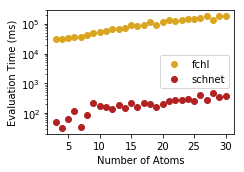

In [9]:
fig, ax = plt.subplots()

for (gid, group), color in zip(results.groupby('model'), ['goldenrod', 'firebrick']):
    ax.semilogy(group['n_atoms'], group['timing'],# yerr=data['timing_err'], 
                color=color, linestyle='none', marker='o',
               label=gid.split("_")[-1])
ax.set_xlabel('Number of Atoms')
ax.set_ylabel('Evaluation Time (ms)')
ax.legend()

fig.set_size_inches(3.5, 2.5)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'dlhub-run-time.png'), dpi=320)
fig.savefig(os.path.join('figures', 'dlhub-run-time.pdf'))